Credit Card Fraud Detection Using Machine Learning

In [1]:
#!pip install tpot
#!pip install scikit-learn-intelex
#!pip install mlxtend
#!pip install tpot
#!pip install xgboost
#!pip install hyperopt
#!pip install imblearn
#!pip install xlwt
#!pip install seaborn
#!pip install xgboost==1.7
#!pip install matplotlib

In [65]:
from sklearnex import patch_sklearn  #This is a library to accelerate existing scikit-learn code
patch_sklearn() #For more info: https://github.com/intel/scikit-learn-intelex

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
from mlxtend.classifier import StackingCVClassifier
from scipy.stats import uniform, randint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, power_transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import ADASYN
import hyperopt 
from hyperopt.pyll import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from warnings import filterwarnings

filterwarnings("ignore")
np.random.seed(0)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


General information about the data:

In [66]:
credit_card=pd.read_csv("creditcard.csv")
pd.set_option('display.float_format', '{:.2f}'.format)
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [67]:
credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [68]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 284807 entries, 0 to 284806

Data columns (total 31 columns):

 #   Column  Non-Null Count   Dtype  

---  ------  --------------   -----  

 0   Time    284807 non-null  float64

 1   V1      284807 non-null  float64

 2   V2      284807 non-null  float64

 3   V3      284807 non-null  float64

 4   V4      284807 non-null  float64

 5   V5      284807 non-null  float64

 6   V6      284807 non-null  float64

 7   V7      284807 non-null  float64

 8   V8      284807 non-null  float64

 9   V9      284807 non-null  float64

 10  V10     284807 non-null  float64

 11  V11     284807 non-null  float64

 12  V12     284807 non-null  float64

 13  V13     284807 non-null  float64

 14  V14     284807 non-null  float64

 15  V15     284807 non-null  float64

 16  V16     284807 non-null  float64

 17  V17     284807 non-null  float64

 18  V18     284807 non-null  float64

 19  V19     284807 non-null  float64

 20  V20     284807 non-null

Class needed to be categorical.

In [69]:
credit_card["Class"]=credit_card["Class"].astype("category")

Let' see if there are any null. (There isn't.)

In [70]:
print("Total None values:", credit_card.isna().any().sum())

Total None values: 0


Let's see how many transactions are fraudulent.

In [71]:
credit_card["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

It's are extremly imbalanced

In [72]:
def get_axes_list(length, column_number=2):
    fig, axes_list = get_fig_and_axes_list(length, column_number=column_number )
    return axes_list

In [73]:
def get_fig_and_axes_list(plot_count, column_number=2):
    """
    This function takes in the number of subplots to be plotted and the desired number of columns for the subplot grid. 
    It then calculates the number of rows required and generates a matplotlib figure with the given number of subplots 
    in a grid with the desired number of columns.
    
    Args:
    - plot_count: int, the number of subplots to be plotted
    - column_number: int, the number of columns in the subplot grid. Default value is 2.
    
    Returns:
    - fig: matplotlib Figure object, the generated figure
    - axes_list: list of matplotlib Axes objects, the axes of the subplots in the figure
    """
    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 4.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_num):
        for j in range(column_number):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

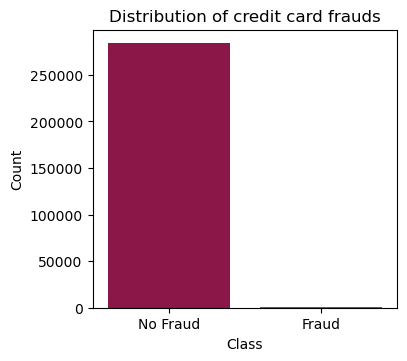

In [74]:
ax = get_axes_list(1)[0]
sns.set_palette("PuRd_r")
bar = sns.countplot(x=credit_card["Class"],ax=ax)
ax.set_xticklabels(['No Fraud', 'Fraud'])
ax.set_xlabel("Class")
ax.set_ylabel("Count")
bar.set_title('Distribution of credit card frauds')
plt.show()

Distribution by time:

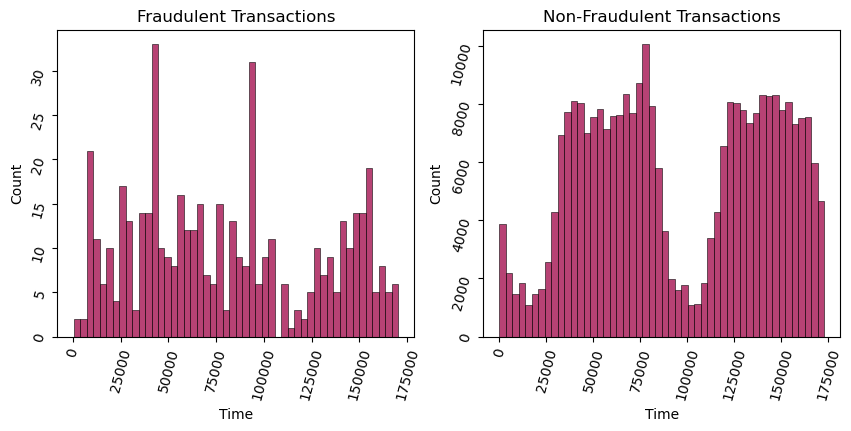

In [75]:
axes = get_axes_list(2,2)
trans_plots = []
trans_plots.append(sns.histplot(credit_card["Time"][credit_card.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(credit_card["Time"][credit_card.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
plt.show()

#### Let's apply a necessary transform for Amount. It's highly skewed. We apply power transformation(basically you can think that taking the logarithm for this example).

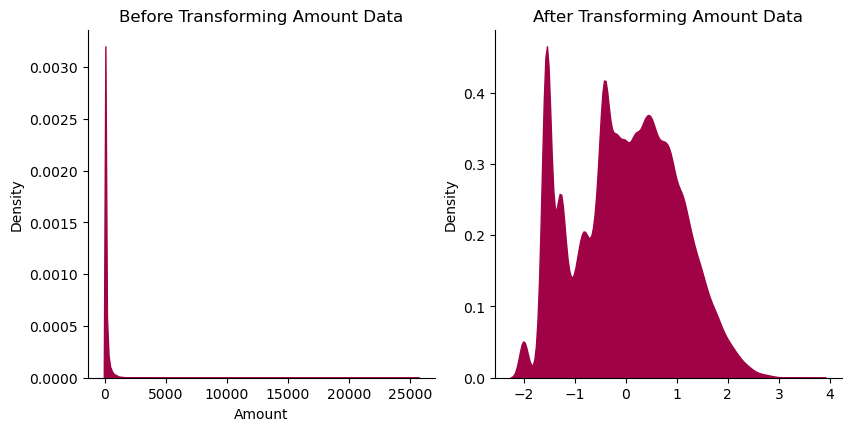

In [76]:
data_transformed = power_transform(credit_card[["Amount"]])
axes = get_axes_list(2,2)
rel_plots = []
rel_plots.append(sns.kdeplot(x=credit_card["Amount"], fill=True, alpha=1, ax=axes[0]))
rel_plots[0].set_title('Before Transforming Amount Data') 
rel_plots.append(sns.kdeplot(x=data_transformed.ravel(), fill=True, alpha=1, ax=axes[1]))
rel_plots[1].set_title('After Transforming Amount Data') 
sns.despine()
plt.show()

In [77]:
credit_card["Amount"] = data_transformed #Apply the transformation.

In [15]:
#Split the dataset
X = credit_card.drop("Class", axis=1)
y=credit_card["Class"].values
rand_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=rand_state, stratify=y)

In [16]:
#Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
#Our results DataFrame
results = pd.DataFrame(columns=["Function Name", "Accuracy", "Precision", "Recall", "F1",
                               "TN", "FP", "FN", "TP", "ROC-AUC Score", "Precision-Recall Score", "Train CV Score"])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state) #We use stratified becuse of imbalanced dataset. 
kf_for_test = StratifiedKFold(n_splits=6, shuffle=True, random_state=0) #We use another one for testing different cross validations

Some functions to tune algorithms :)

In [18]:
def tune_log_reg(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    log_reg_params = {"solver": ["liblinear"],
                      #"penalty": ['l1', "l2"],
                      'C': [0.001, 0.01, 0.1, 1, 10, 100],
                      "class_weight": [{0:1, 1:w} for w in list(range(1,100,40))]}
    grid_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=100000,n_jobs=-1),
                                      log_reg_params, cv=kf, n_iter=2, n_jobs=-1, scoring=scoring, verbose=1)
    grid_log_reg.fit(X, y)#If you have time, don't hesitate to increase number of iterations
    return grid_log_reg.best_estimator_

In [19]:
def tune_dec_tree(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    tree_params = {"criterion": ["gini", "entropy"],
                   "max_depth": list(range(2,5,1)),
                   "min_samples_leaf": list(range(5,7,1)), 
                   "class_weight": [{0:1, 1:w} for w in list(range(1,100,20))]}
    grid_tree = RandomizedSearchCV(DecisionTreeClassifier(),
                                    tree_params, cv=kf, n_iter=7, n_jobs=-1,scoring=scoring, verbose=1)
    grid_tree.fit(X, y)
    return grid_tree.best_estimator_

In [20]:
def tune_knn(X=X_train_scaled, y=y_train, scoring="average_precision", cv=kf):
    knears_params = {"n_neighbors": list(range(2,5,1)), 
                     'metric' : ['minkowski','euclidean','manhattan'],
                     "weights": ["uniform", "distance"]}
    grid_knears = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), knears_params, cv=kf, n_iter=20, scoring=scoring, verbose=1)
    grid_knears.fit(X, y)
    return grid_knears.best_estimator_

In [21]:
def tune_xgb(X=X_train_scaled,y=y_train, scoring="average_precision", cv=kf):
    params = {"colsample_bytree": uniform(0.7, 0.1),
              "gamma": uniform(0, 0.5),
              "learning_rate": uniform(0.03, 0.5),
              "max_depth": randint(2, 25),
              "n_estimators": randint(100, 250),
              "subsample": uniform(0.7, 0.3),
              "max_delta_step": randint(1,10) }
    grid_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective="binary:logistic",eval_metric=average_precision_score ,n_jobs=-1, tree_method="hist", random_state=rand_state),
                                  params, cv=kf, n_iter=20, scoring=scoring)
    grid_xgb.fit(X, y)
    return grid_xgb.best_estimator_

In [22]:
def tune_sgd_bayes(X=X_train_scaled, y=y_train, scoring="average_precision",cv=kf):
    def objective_for_minimization(search_space, X=X, y=y, scoring_objective=scoring):
        model = SGDClassifier(**search_space, max_iter=int(1e9), n_jobs=-1, random_state=rand_state)
        best_score = cross_val_score(model, X, y, scoring=scoring_objective, cv=kf, n_jobs=-1).mean()
        loss = 1 - best_score
        return {'loss': loss, 'status': STATUS_OK}
    
    search_space = {"penalty" : hp.choice("penalty", ['l1', 'l2', 'elasticnet']),
                    "alpha" : hp.uniform("alpha",0.00001, 3),
                    "learning_rate" : hp.choice("learning_rate",['constant', 'optimal', 'invscaling', 'adaptive']), 
                    'eta0':hp.uniform('n_estimators',0,3),
                    "power_t": hp.uniform('power_t',-0.1,1),
                    "validation_fraction": hp.uniform('validation_fraction',0.1,0.3),
                    'loss':hp.choice("loss",['modified_huber']),
                    'class_weight': {0:1, 1:scope.int(hp.uniform('class_weight', 1, 100))}
                   }
    # implement Hyperopt
    algorithm = tpe.suggest
    best_params = fmin(fn=objective_for_minimization,
                       space=search_space,
                       algo=algorithm,
                       max_evals=40)
    fun_params_dict=space_eval(search_space, best_params)
    return SGDClassifier(**fun_params_dict, n_jobs=-1)

If we want to cross-validate our data, wee need to do it during cross-validation. The reason is not to contaminate our training data with sampled data! This function resolves the problem.

In [23]:
def cross_val_score_for_sampling(model, X_train, y_train, cv=kf_for_test, 
                                 results=results, undersample=False, 
                                 oversample=False, stack=False, other=False):  
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
    scores_dict = {metric: [] for metric in scoring_metrics}
    sampling_methods = {'undersample': NearMiss(sampling_strategy='majority', n_jobs=-1, version=3),
                        'oversample': ADASYN(random_state=rand_state)}
    sample_pipeline = make_pipeline(model)
    if undersample:
        sample_pipeline.steps.insert(0, ('undersample', sampling_methods['undersample']))
    if oversample:
        sample_pipeline.steps.insert(0, ('oversample', sampling_methods['oversample']))
    for train_idx, test_idx in cv.split(X_train, y_train):
        sample_model = sample_pipeline.fit(X_train[train_idx], y_train[train_idx])
        sample_prediction_proba = sample_model.predict_proba(X_train[test_idx])[:,1]
        sample_prediction = np.round(sample_prediction_proba)
        scores_dict["accuracy"].append(accuracy_score(y_train[test_idx], sample_prediction))
        scores_dict["precision"].append(precision_score(y_train[test_idx], sample_prediction))
        scores_dict["recall"].append(recall_score(y_train[test_idx], sample_prediction))
        scores_dict["f1"].append(f1_score(y_train[test_idx], sample_prediction))
        scores_dict["roc_auc"].append(roc_auc_score(y_train[test_idx], sample_prediction_proba))
        scores_dict["average_precision"].append(average_precision_score(y_train[test_idx], sample_prediction_proba))
    return  scores_dict

In [24]:
def get_scoring_name(scoring):
    equal = {"accuracy": "Accuracy", 
             "precisione": "Precision", 
             "recall": "Recall", 
             "f1": "F1", 
             "roc_auc": "ROC AUC", 
             "average_precision": "AP AUC"} 
    return equal[scoring]

In [25]:
def get_training_cross_validated_score(model, X_train, y_train, undersample=False, oversample=False, stack=False, other=False, scoring="Accuracy"):
    try:
        if undersample or oversample or stack:
            training_cross_validated_score = np.mean(
                cross_val_score_for_sampling(
                    model, X_train, y_train, undersample=undersample, oversample=oversample, stack=stack, other=other)[scoring])
        elif other:
            return None
        else:
            training_cross_validated_score = cross_val_score(
                model, X_train, y=y_train, cv=kf, scoring=scoring, n_jobs=-1).mean()
        return training_cross_validated_score
    except Exception as e:
        return None

In [26]:
def print_scores(models, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, 
                 y_test=y_test, result_prefix="",results=results, undersample=False, 
                 oversample=False, stack=False, other=False, scoring="average_precision"):
    """
    Plot confusion matrices and evaluation metrics for a dictionary of models.

    Parameters:
    -----------
    models : dict
        A dictionary of scikit-learn models to evaluate.
    X_train : array-like, shape (n_samples, n_features), default=X_train_scaled
        The training input samples.
    X_test : array-like, shape (n_samples, n_features), default=X_test_scaled
        The testing input samples.
    y_train : array-like, shape (n_samples,), default=y_train
        The target values of the training input samples.
    y_test : array-like, shape (n_samples,), default=y_test
        The target values of the testing input samples.
    result_prefix : str, default=""
        A prefix to add to the function name in the results DataFrame.
    results : pandas.DataFrame, default=results
        A DataFrame to store the results.
    undersample : bool, default=False
        Whether to perform undersampling during cross-validation on training set.
    oversample : bool, default=False
        Whether to perform oversampling during cross-validation on training set.
    stack : bool, default=False
        Whether Stacking Classifier will be used during cross-validation on training set.
    other : bool, default=False
        Whether cross-validation will be used on training set.
    scoring : str or callable, default="average_precision"
        The scoring metric to use for cross validation.

    Returns:
    --------
    None
    """
    ax_list =get_axes_list(len(models))
    ax_counter = 0
    for i, (name, model) in enumerate(models.items()):
        model_name = model.__class__.__name__
        ax_of_model = ax_list[i]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        if hasattr(model, "predict_proba"):
            predicted_prob = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, predicted_prob)
            average_precision = average_precision_score(y_test, predicted_prob)
        else:
            predicted_prob = None
            roc_auc = None
            average_precision = None
        training_cross_validated_score = get_training_cross_validated_score(
            model, X_train, y_train, undersample=undersample, oversample=oversample, stack=stack, other=other, scoring=scoring)
        scoring_name = get_scoring_name(scoring)
        scoring_variable = locals()[scoring]
        if training_cross_validated_score and scoring_variable:
            ax_of_model.set_title(f"{model_name} \n ({scoring_name}: {scoring_variable:3.2f} || Train {scoring_name}: {scoring_variable:3.2f})",
                                  fontdict={'fontsize':10})
        elif scoring_variable:
            ax_of_model.set_title(f"{model_name} \n ({scoring_name} score: {scoring_variable:3.2f})")
        else:
            ax_of_model.set_title(f"{model_name}")
        function_name = f"{model_name}{result_prefix}"    
        function_location = results[results["Function Name"] == function_name].index
        index_to_insert=(len(results.index) if function_location.empty else function_location[0])
        results.loc[index_to_insert] = [function_name, accuracy,
                                        precision, recall, f1, tn, fp, fn, tp, roc_auc, 
                                        average_precision, training_cross_validated_score] 
        labels_ = ['No Fraud', 'Fraud']
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels_, 
                                                ax=ax_of_model, cmap='Blues', xticks_rotation="vertical")
        #print(classification_report(y_test, y_pred)) #If you want to get classification report.
    plt.show()

# Modeling

First try with default parameters.

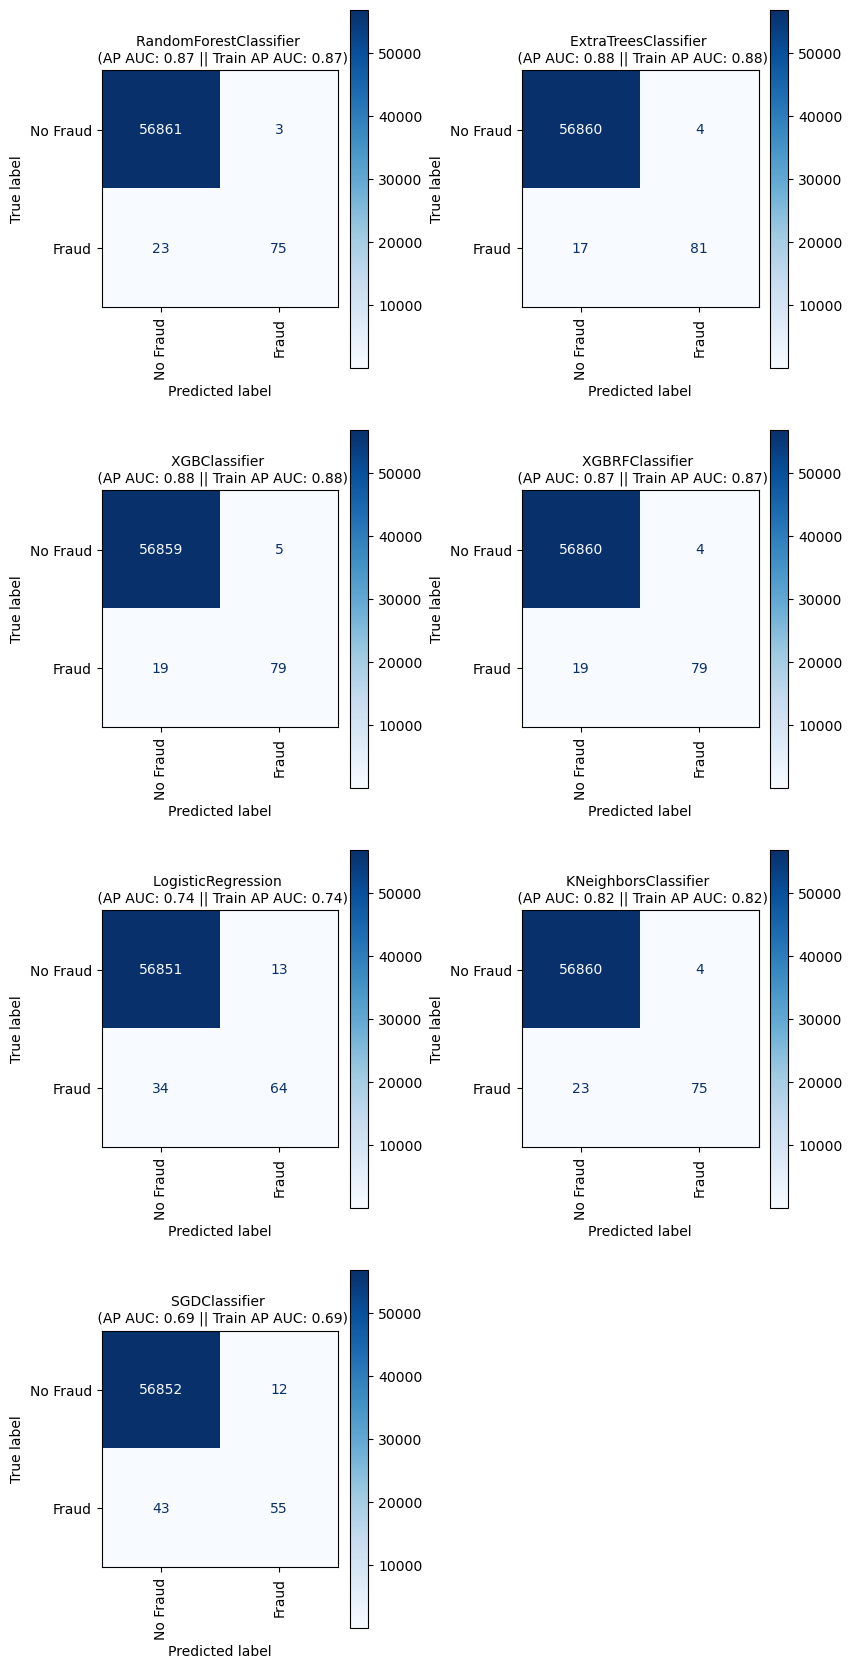

In [27]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, 
                                              tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, 
                                                              tree_method="hist", random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "SGD": SGDClassifier(n_jobs=-1, loss="log")}
print_scores(models)

#### And try Voting Classifier.

A voting classifier is a machine learning technique that combines the predictions of multiple models to make a final prediction. This ensemble approach can improve the accuracy and stability of predictions, especially when individual models are prone to error or have biases. 

In [28]:
clf_meta=xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist", random_state=rand_state)
classifiers_stack=[ExtraTreesClassifier(n_jobs=-1),
                   RandomForestClassifier(n_jobs=-1),
                   xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, 
                                     tree_method="hist", random_state=rand_state),
                   xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score,
                                       n_jobs=-1, tree_method="hist", random_state=rand_state),
                   LogisticRegression(solver="liblinear",n_jobs=-1,max_iter=int(1e9), class_weight="balanced"),
                   KNeighborsClassifier(n_jobs=-1),
                   SGDClassifier(loss="modified_huber", n_jobs=-1,max_iter=int(1e9), class_weight="balanced")]
clf_stack = StackingCVClassifier(classifiers=classifiers_stack,
                                 meta_classifier=clf_meta,
                                 cv=kf,
                                 verbose=False,
                                 use_probas=True,
                                 use_features_in_secondary=True)

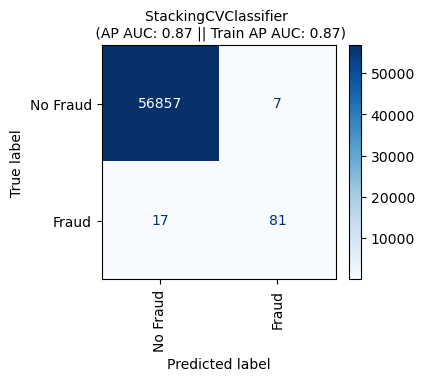

In [29]:
vc ={"Stack": clf_stack }
print_scores(vc, stack=True, result_prefix="_voting_stack")

#### Tuning

Now let's try tuning according to AP score.

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Fitting 5 folds for each of 18 candidates, totalling 90 fits

100%|███████████████████████████████████████████████| 40/40 [01:40<00:00,  2.52s/trial, best loss: 0.23270564654179404]


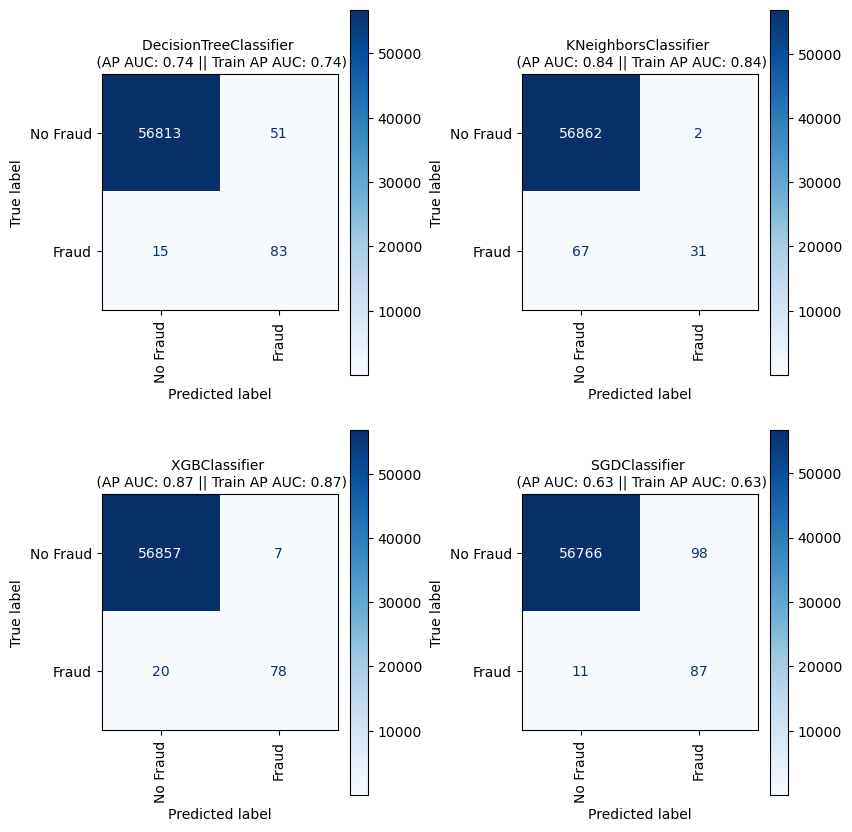

In [30]:
tree_clf_ap = tune_dec_tree()
#log_reg_ap = tune_log_reg()
knears_neighbors_ap = tune_knn()
xgb_est_ap = tune_xgb()
sgd_est_ap = tune_sgd_bayes()
models_with_params={"Decision Tree": tree_clf_ap,
                    "KNN": knears_neighbors_ap,
                    #"Logistic Regression": log_reg_ap,
                    "XGB": xgb_est_ap, 
                    "SGD":sgd_est_ap}
print_scores(models_with_params,result_prefix="_tuned_ap")

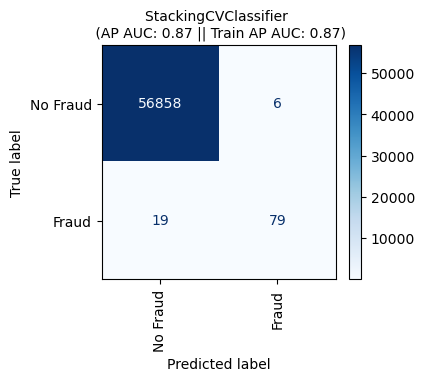

In [31]:
classifiers_tuned_ap=[tree_clf_ap, knears_neighbors_ap, xgb_est_ap, sgd_est_ap]# You can include log_reg_ap
clf_stack_tuned_ap=StackingCVClassifier(classifiers=classifiers_tuned_ap,
                                 meta_classifier=clf_meta,
                                 cv=kf,
                                 verbose=False,
                                 use_probas=True,
                                 use_features_in_secondary=True)
vc ={"Stack": clf_stack_tuned_ap }
print_scores(vc, stack=True, result_prefix="_voting_stack_tuned_ap")

# Oversampling

If we apply ADASYN(It's a oversampling algorithm technique for imbalanced datasets.):

In [32]:
method = ADASYN(random_state=rand_state)
X_train_resampled, y_train_resampled = method.fit_resample(X_train_scaled, y_train)

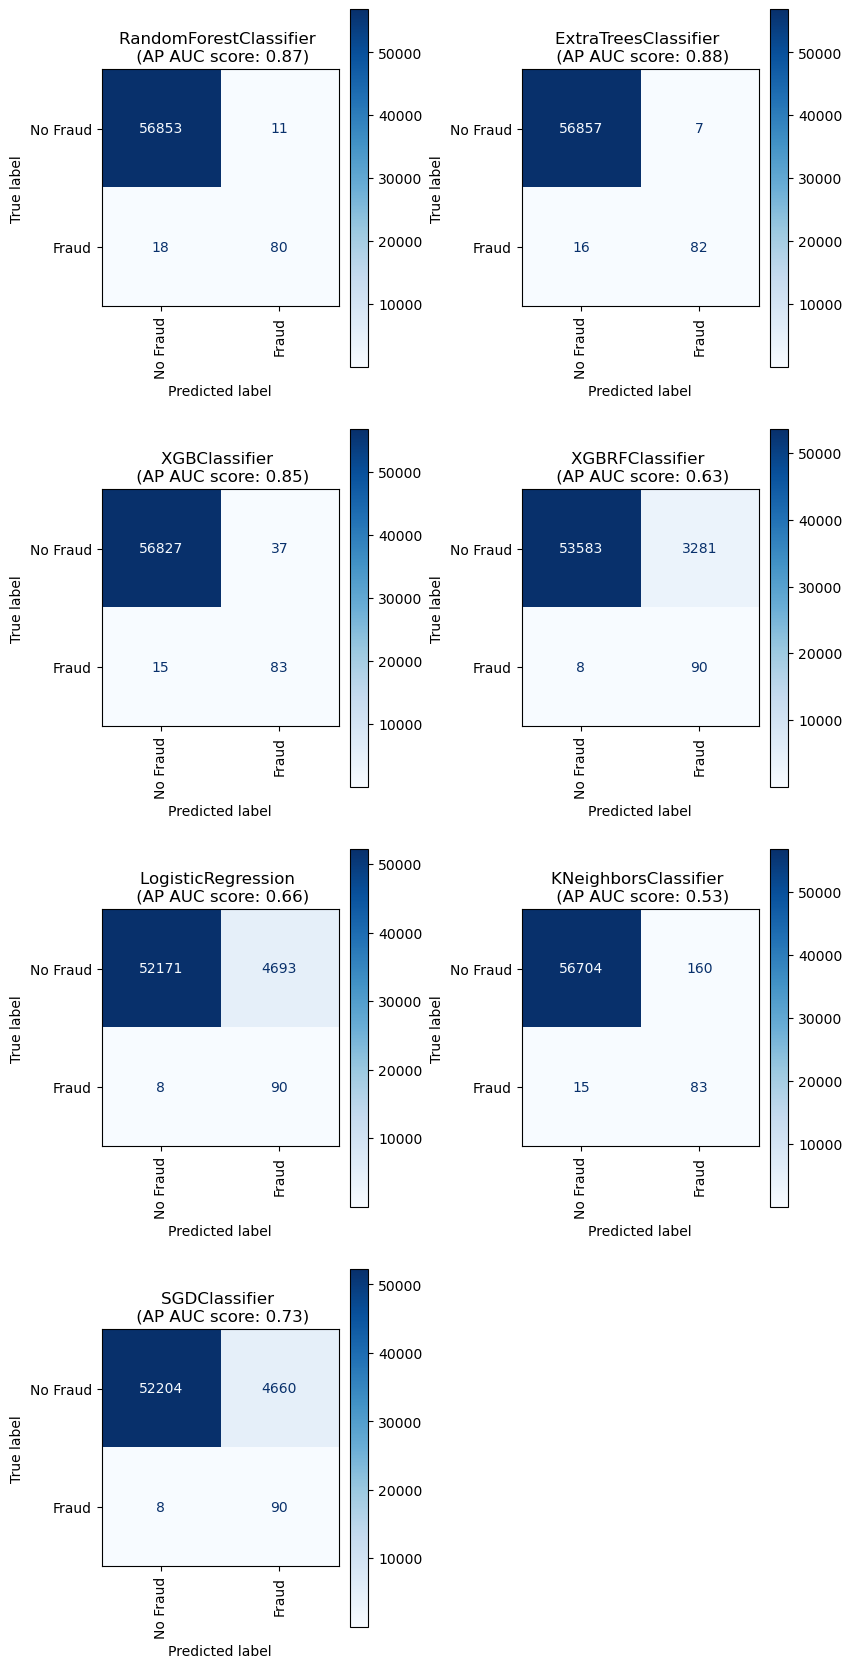

In [33]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra Trees":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, 
                                              tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", eval_metric=average_precision_score, 
                                                              tree_method="hist", random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "SGD": SGDClassifier(n_jobs=-1, loss="log")}
print_scores(models, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_adasyn")

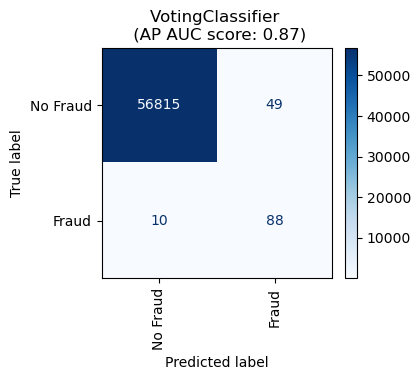

In [34]:
classifiers =[("Extra Trees", ExtraTreesClassifier(n_jobs=-1)),
              ("Random Forest", RandomForestClassifier(n_jobs=-1)),
              ("XGB Classifier", xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, tree_method="hist")), 
              ("XGB Random Forest Classifier", xgb.XGBRFClassifier(objective="binary:logistic", n_jobs=-1, 
                                                                   tree_method="hist", eval_metric=average_precision_score)),
              ("Logistic Regression", LogisticRegression(max_iter=100000,n_jobs=-1)), 
              ("KNN", KNeighborsClassifier(n_jobs=-1)), 
              ("Decision Tree", DecisionTreeClassifier()),
              ("SGD", SGDClassifier(loss="log", n_jobs=-1))]

vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) } 
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_adasyn")

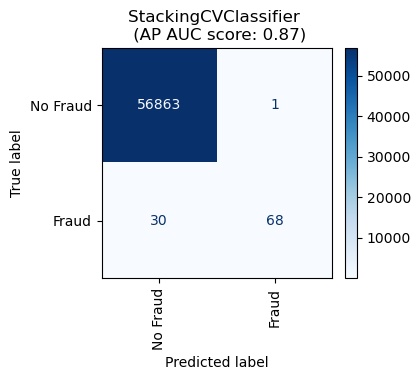

In [35]:
vc ={"Stack": clf_stack }
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_stack_adasyn")

#### Tuning

Let's see if we can get any better by tuning.

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Fitting 5 folds for each of 18 candidates, totalling 90 fits


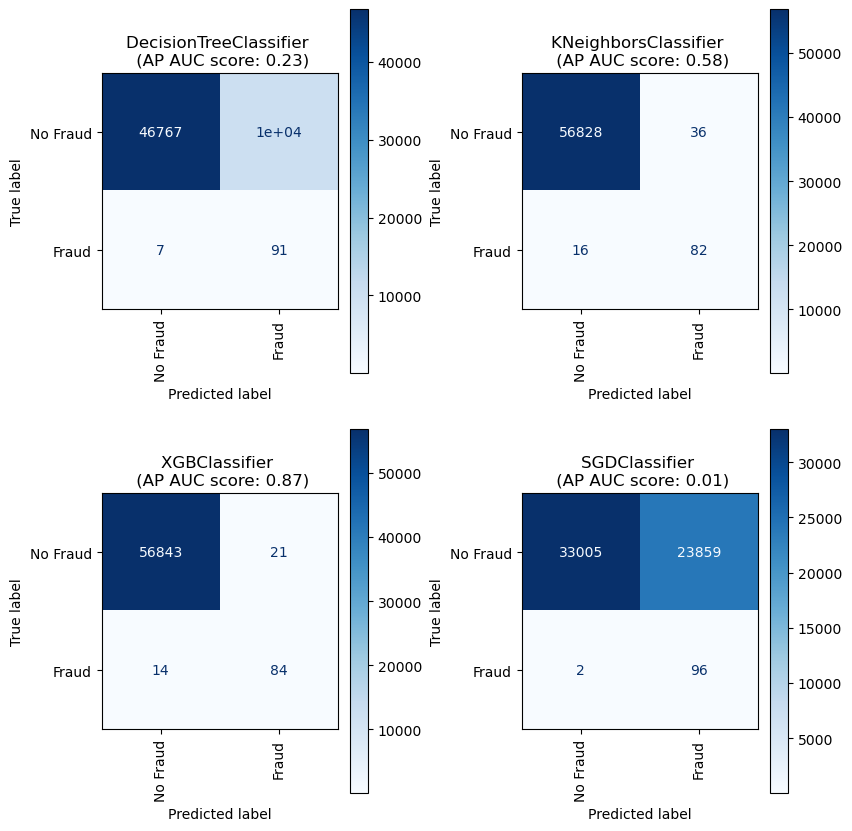

In [36]:
#log_reg_adasyn_ap = tune_log_reg(X=X_train_resampled, y=y_train_resampled)
tree_clf_adasyn_ap = tune_dec_tree(X=X_train_resampled, y=y_train_resampled)
knears_neighbors_adasyn_ap = tune_knn(X=X_train_resampled, y=y_train_resampled)
xgb_est_adasyn_ap = tune_xgb(X=X_train_resampled, y=y_train_resampled)
models_with_params={"Decision Tree": tree_clf_adasyn_ap,
                    "KNN": knears_neighbors_adasyn_ap,
                    #"Logistic Regression": log_reg_adasyn_ap, #takes too long
                    "XGB": xgb_est_adasyn_ap, 
                    "SGD":sgd_est_ap}
print_scores(models_with_params, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_adasyn_tuned_ap")

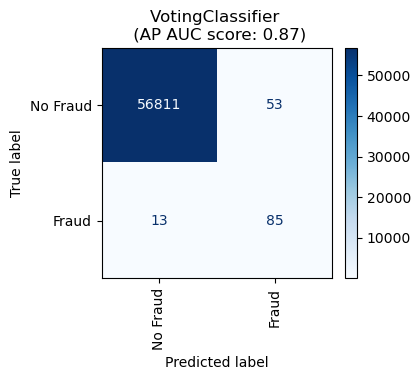

In [37]:
classifiers =[("XGB Classifier", xgb_est_adasyn_ap),
              #("Logistic Regression", log_reg_adasyn_ap),
              ("KNN", knears_neighbors_adasyn_ap),
              ("Decision Tree", tree_clf_adasyn_ap)]
vc ={"Vote": VotingClassifier(estimators=classifiers,voting="soft",n_jobs=-1) }    
print_scores(vc, X_train=X_train_resampled, y_train=y_train_resampled, oversample=True, result_prefix="_voting_adasyn_tuned_ap")

# Undersampling

First we'll do random undersampling for dimensionality reduction and correlation matrix then use Near Miss algorithm for actual undersampling modeling.

In [38]:
X_scaled_for_rus = credit_card.drop(columns="Class")
y_scaled_for_rus = credit_card.Class
X_scaled_for_rus = scaler.fit_transform(X_scaled_for_rus)

In [39]:
rus=RandomUnderSampler(random_state=rand_state)
X_rus, y_rus=rus.fit_resample(X_scaled_for_rus, y_scaled_for_rus)

In [40]:
Counter(y_rus)

Counter({0: 492, 1: 492})

#### If we apply Dimensionality Reduction techniques:

In [41]:
# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=rand_state, n_jobs=-1).fit_transform(X_rus)

# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=rand_state).fit_transform(X_rus)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, random_state=rand_state).fit_transform(X_rus)

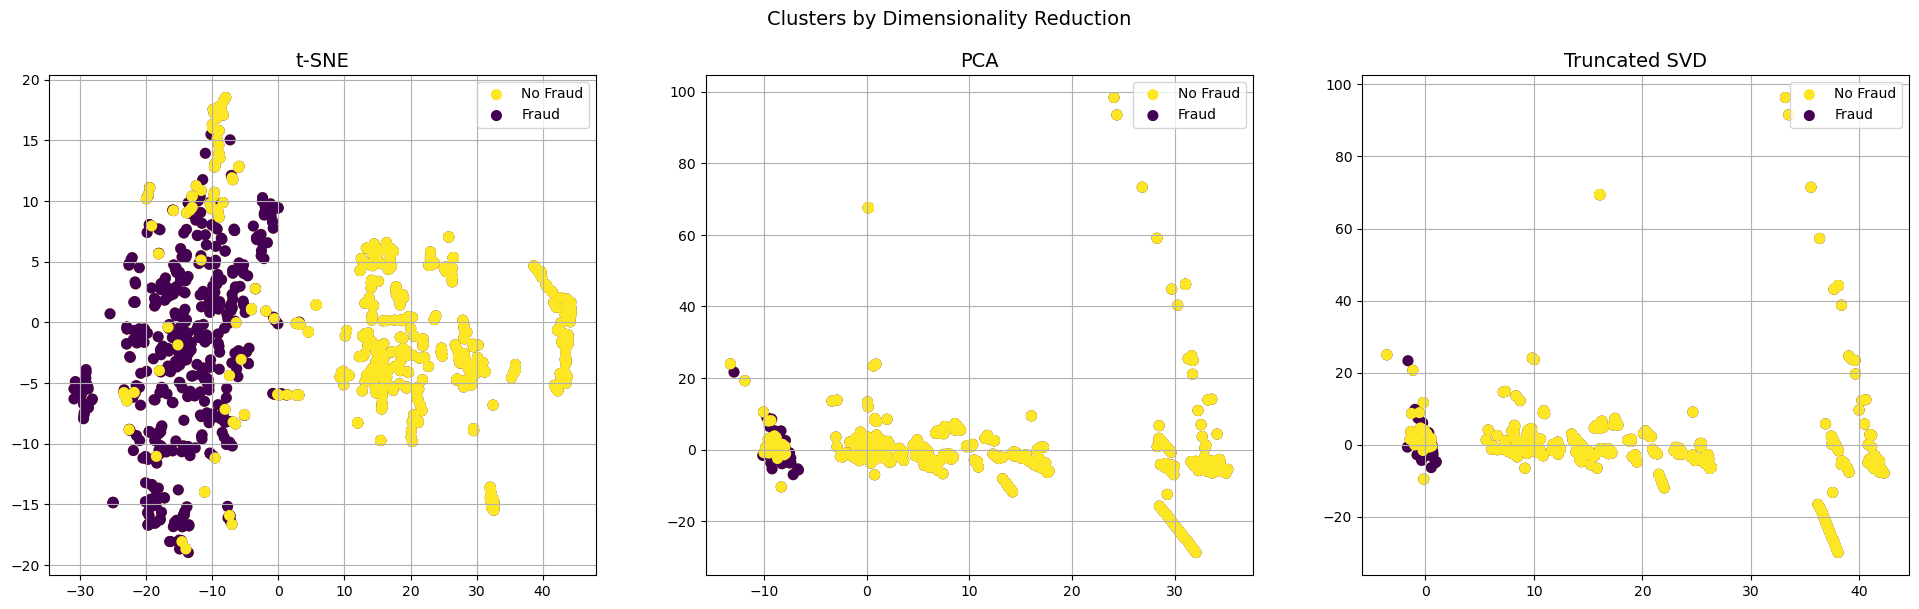

In [42]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6.5))
f.suptitle('Clusters by Dimensionality Reduction', fontsize=14)

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend()

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend()

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 0), label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_rus == 1), label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend()

plt.show()

#### Let's apply NearMiss(It's a undersampling algorithm technique for imbalanced datasets.):

In [43]:
nm = NearMiss(version=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train_scaled, y_train)

In [44]:
Counter(y_train_nm)

Counter({0: 363, 1: 394})

In [45]:
new_df=pd.DataFrame(X_train_nm, columns=credit_card.drop("Class", axis=1).columns)
new_df["Class"]=y_train_nm

See correlation matrix. (We did this right after undersampling to see correlations clearly.)

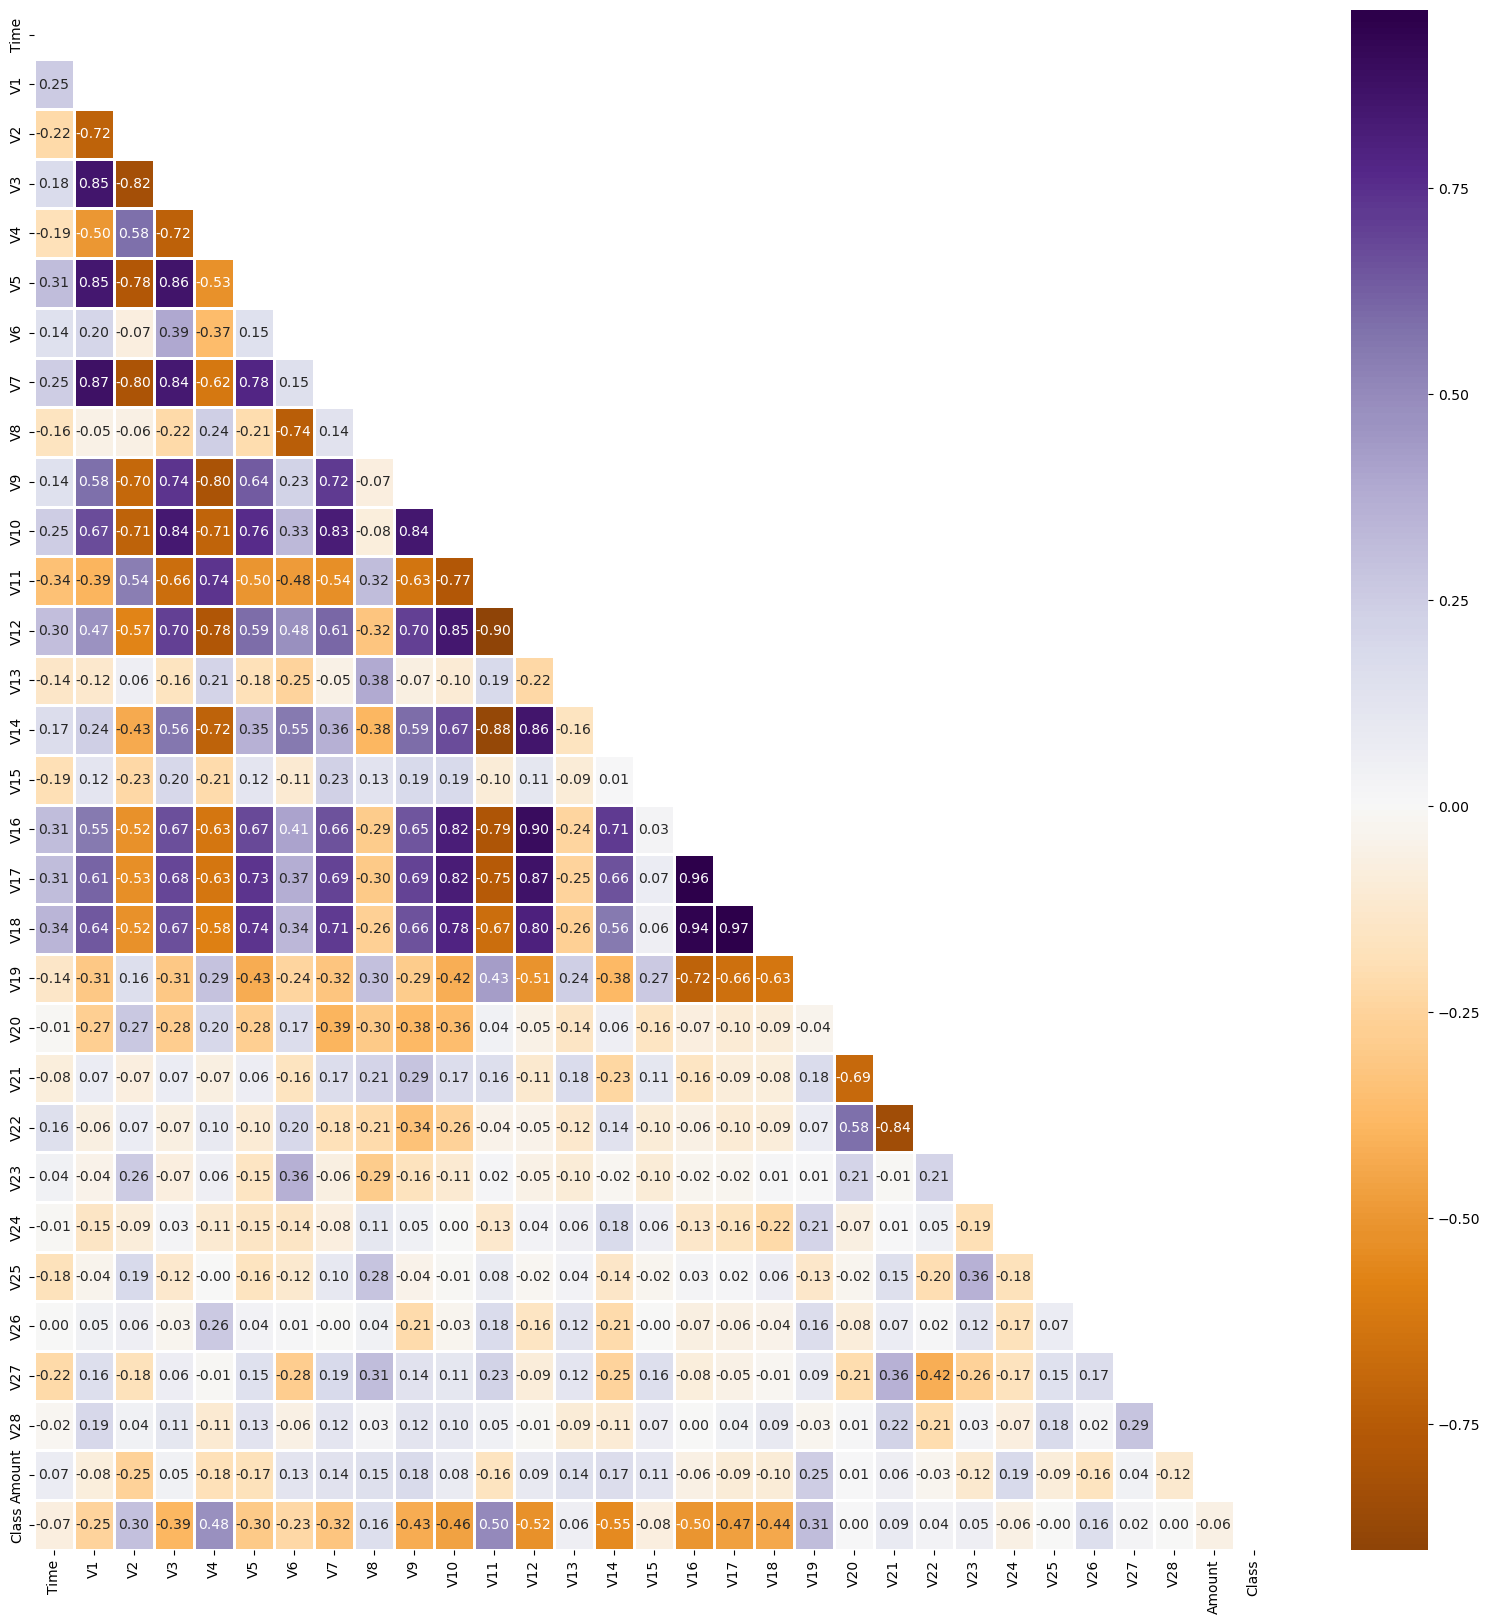

In [46]:
plt.figure(figsize = (20,20))
corr = new_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))# Generate a mask for the upper triangle 
ax = sns.heatmap(corr, cmap='PuOr', mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

Now try algorithms and Voting Classifier:

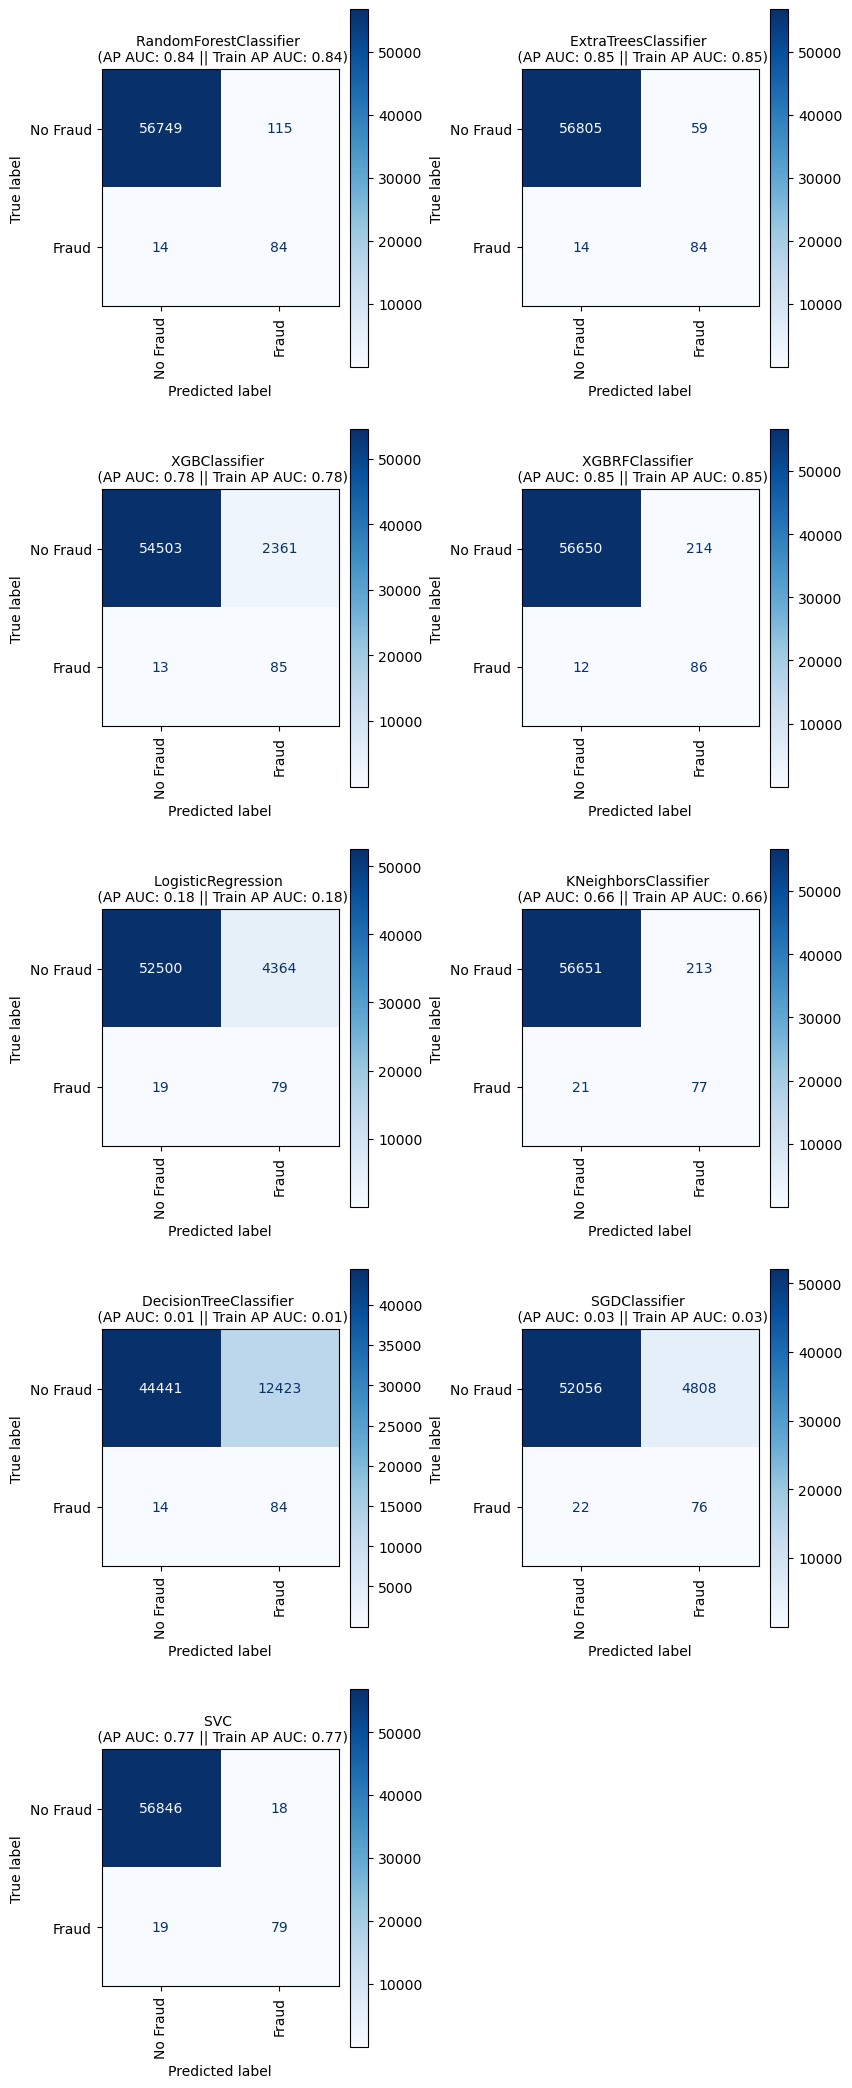

In [47]:
models = {"Random Forest":RandomForestClassifier(n_jobs=-1, random_state=rand_state),
          "Extra":ExtraTreesClassifier(n_jobs=-1),
          "XGB Classifier": xgb.XGBClassifier(eval_metric=average_precision_score, n_jobs=-1, 
                                              tree_method="hist", random_state=rand_state),
          "XGB Random Forest Classifier": xgb.XGBRFClassifier(objective="binary:logistic", n_jobs=-1, tree_method="hist", 
                                                              eval_metric=average_precision_score, random_state=rand_state),
          "Logistic Regression": LogisticRegression(n_jobs=-1),
          "KNN": KNeighborsClassifier(n_jobs=-1), 
          "Decision Tree": DecisionTreeClassifier(),
          "SGD": SGDClassifier(loss="log", n_jobs=-1),
          "Support Vector Classifier":SVC(probability=True)}
print_scores(models, X_train=X_train_nm, y_train=y_train_nm, undersample=True, result_prefix="_us")

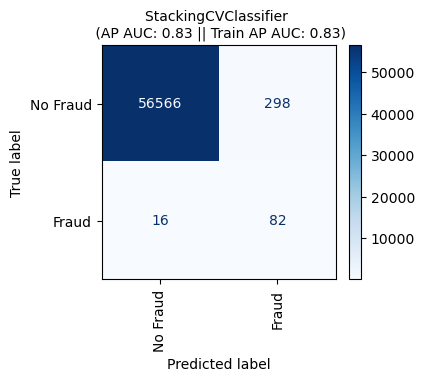

In [48]:
vc ={"Stack": clf_stack }
print_scores(vc, X_train=X_train_nm, y_train=y_train_nm, undersample=True, result_prefix="_voting_stack_us")

# Bonus: TPOT

Last but not least. Let's try TPOT. It's is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. Let's try it.

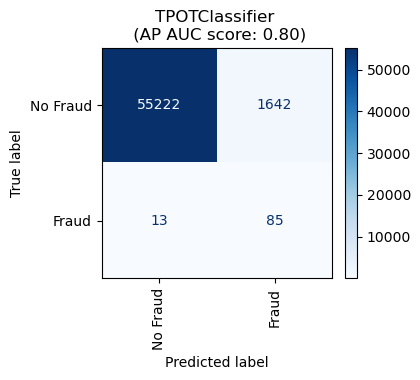

In [49]:
try: 
    from tpot import TPOTClassifier
    # If you have time, then don't hesitate increasing generations ,offspring_size and population_size
    TPOT_model_us = TPOTClassifier(generations=30,offspring_size=20, scoring='average_precision', cv=kf, 
                                     population_size=20, verbosity=0, n_jobs=-1, random_state=rand_state)
    models = {"TPOT": TPOT_model_us}
    print_scores(models, X_train=X_train_nm, y_train=y_train_nm, other=True, result_prefix="_us_TPOT") 
except Exception as e:
    print(e,"Packages have conficlict.")

In [50]:
TPOT_model_us.fitted_pipeline_ 

Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=8,
                                            max_features=0.6500000000000001,
                                            min_samples_leaf=14,
                                            min_samples_split=4,
                                            random_state=42,
                                            subsample=0.7000000000000001))])

In [64]:
#Drop accuracy because we don't need because of imbalanced dataset
results.drop("Accuracy", axis=1).sort_values(by="Precision-Recall Score",ascending=False).style.format(precision=3)\
                    .highlight_max(subset=["Precision-Recall Score","ROC-AUC Score","Train CV Score"], color ='lightgreen')

,Function Name,Precision,Recall,F1,TN,FP,FN,TP,ROC-AUC Score,Precision-Recall Score,Train CV Score
14,ExtraTreesClassifier_adasyn,0.921,0.837,0.877,56857,7,16,82,0.967,0.883,None
1,ExtraTreesClassifier,0.953,0.827,0.885,56860,4,17,81,0.953,0.878,0.852
2,XGBClassifier,0.940,0.806,0.868,56859,5,19,79,0.978,0.877,0.846
7,StackingCVClassifier_voting_stack,0.920,0.827,0.871,56857,7,17,81,0.979,0.875,0.856
21,StackingCVClassifier_voting_stack_adasyn,0.986,0.694,0.814,56863,1,30,68,0.951,0.872,None
10,XGBClassifier_tuned_ap,0.918,0.796,0.852,56857,7,20,78,0.978,0.871,0.851
24,XGBClassifier_adasyn_tuned_ap,0.800,0.857,0.828,56843,21,14,84,0.983,0.870,None
0,RandomForestClassifier,0.962,0.765,0.852,56861,3,23,75,0.922,0.869,0.843
3,XGBRFClassifier,0.952,0.806,0.873,56860,4,19,79,0.971,0.868,0.833
20,VotingClassifier_voting_adasyn,0.642,0.898,0.749,56815,49,10,88,0.977,0.868,None


Best results highlited. I will be waiting for your feedback :)

In [52]:
results.to_excel('results_7.1.xls', index=False)